# A Look at the Top Soccer Leagues

In this project I look at some statistics using soccer data. 

The original data is stored in a relational database which I first query with SQL and then convert into a pandas dataframe. However, most relevant data in this dataframe is stored in xml format. I convert the data from .xml to dictionaries and then I create three different dataframes. One will store data about the *game*, such as number of fouls committed by the home team, or the possession ratio. A second table will store data about *goals* (who scored, who assisted, what type of goal is it?) and finally I will build a table with data on *players*.

Moving on to the data analysis part, the statistics are mainly of two kinds. In the first part, I ask the following questions: 

### (1) What is the relation between a team's possession and that team's number of shots? 

### (2) What is the relation between the total number of fouls committed in a game versus the total number of shots in a game?

### (3) What is the relation between the number of fouls committed by a team and that team's number of shots?

### (4) Finally, what is the relation between the number of fouls committed by an opposing team and that team's number of shots?

In the second part, I look at some individual statistics: the user chooses a league and season, and I answer the following questions: 

### (1) Who are the highest scorers? 

### (2) Who committed most fouls?

### (3) Who was fouled the most? 

### (4) How are all the season's goal times distributed throughout the game?

Because the data I need for these statistics is available only for two seasons (2014/2015 and 2015/2016) I just focus on these seasons. Also, I restrict the study to the top five European leagues: *Premier League* (England), *Bundesliga* (Germany), *Ligue 1* (France), *La Liga* (Spain), and *Serie A* (Italy).

One more general observation: a lot of the relevant data for my study was stored in xml format, so I used a [library](https://pypi.org/project/xmltodict/) that converts from xml format to dictionary format.

Let's begin. More comments on individual steps can be found below. 

First, I use an SQL query to extract the relevant data from the soccer database, and then I save this in a csv file. 

## Run next cell to load all libraries for this project, as well as all the dataframes. 

This will avoid the need to recreate the dtaframes from scratch, which takes a very long time.

In [1]:
import csv
import sqlite3 as sql
import numpy as np
import pandas as pd
import xmltodict
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn
import numpy as np
import statsmodels.api as sm
from numpy.polynomial.polynomial import polyfit


goal_df=pd.read_csv('goal_data.csv')
player_df=pd.read_csv('player_data.csv')
game_df=pd.read_csv('soccer_data.csv')


In [32]:
import csv

import sqlite3 as sql

conn=sql.connect('database.sqlite')

c=conn.cursor()

query='''SELECT league_id, season, match_api_id, home_team_api_id,away_team_api_id,

        home_team_goal,away_team_goal,goal,shoton,shotoff,foulcommit,card,possession

        FROM Match as m

        JOIN League as l

        ON l.id=m.league_id

        WHERE (m.season='2014/2015'

               OR m.season='2015/2016')

            AND (l.name LIKE 'England%'

                OR l.name LIKE 'Germany%'

                OR l.name LIKE 'Spain%'

                OR l.name LIKE 'France%'

                OR l.name LIKE 'Italy%');'''



with open('soccer_data.csv','a') as f:

    writer=csv.writer(f)

    writer.writerow(['league_id','season', 'match_id', 'home_team_id','away_team_id','home_team_goal','away_team_goal',
        'goal','shoton','shotoff','fouls','card','possession'])
    
    for row in c.execute(query):

        writer.writerow(row)

OperationalError: no such table: Match

Next, I load the csv file into a dataframe:

In [80]:
import numpy as np
import pandas as pd

game_df=pd.read_csv('soccer_data.csv')

In [81]:
game_df.shape

(3651, 13)

I make sure there are no duplicates in the dataframe. I also check for null values.

Finally, I display a few rows in the dataframe.

In [82]:
print (game_df.duplicated().value_counts())
game_df.info()

False    3651
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3651 entries, 0 to 3650
Data columns (total 13 columns):
league_id         3651 non-null int64
season            3651 non-null object
match_id          3651 non-null int64
home_team_id      3651 non-null int64
away_team_id      3651 non-null int64
home_team_goal    3651 non-null int64
away_team_goal    3651 non-null int64
goal              3651 non-null object
shoton            3651 non-null object
shotoff           3651 non-null object
fouls             3651 non-null object
card              3651 non-null object
possession        3651 non-null object
dtypes: int64(6), object(7)
memory usage: 370.9+ KB


In [83]:
game_df.head(30)

,league_id,season,match_id,home_team_id,away_team_id,home_team_goal,away_team_goal,goal,shoton,shotoff,fouls,card,possession
0,1729,2014/2015,1723982,9825,9826,2,1,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<possession><value><comment>78</comment><event...
1,1729,2014/2015,1723983,8191,8455,1,3,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<possession><value><comment>35</comment><event...
2,1729,2014/2015,1723984,8197,8668,2,2,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<possession><value><comment>39</comment><event...
3,1729,2014/2015,1723985,8650,8466,2,1,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<possession><value><comment>70</comment><event...
4,1729,2014/2015,1723986,10260,10003,1,2,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<possession><value><comment>60</comment><event...
5,1729,2014/2015,1723987,10261,8456,0,2,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<possession><value><comment>41</comment><event...
6,1729,2014/2015,1723988,10172,8667,0,1,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<possession><value><comment>46</comment><event...
7,1729,2014/2015,1723989,10194,10252,0,1,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<possession><value><comment>57</comment><event...
8,1729,2014/2015,1723990,8659,8472,2,2,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<possession><value><comment>66</comment><event...
9,1729,2014/2015,1723991,8654,8586,0,1,<goal><value><comment>npm</comment><event_inci...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>r</comment><stats><rcard...,<possession><value><comment>38</comment><event...


I will now define some functions I  use to extract data from the xml expressions.

At this stage of the extraction process, I am interested in creating a table with data about the *game* (later on I create tables with data about the players). The table will have the following columns (new columns *in italics*:
league_id	
season
match_id
home_team_id
away_team_id
home_team_goal
away_team_goal
*home_team_fouls	
away_team_fouls	
home_team_shots	
away_team_shots	
home_team_possession
away_team_possession*

`get_fouls_team` takes a dataframe row as input and returns the number of home team and away team fouls. The reason we need to pass a row as an argument in this function is that we need the row number in order to identify the home and away teams.
`get_posesssion(xml_string)` takes an xml_string as input and it returns home and away team possession.
`get_event_team(event,row)` takes a type of event (*shoton* or *shotoff*) and returns event count for home and away teams.

There are three complications I need to deal with here, which stem from the way the data is stored in the dictionary (originally the xml format). 

(1) I need to deal with the case where a game contains no events of a certain type. This is taken care of with a conditional like `if dic[event]!=None:`

(2) The structure of the dictionary is different depending on whether a game has only one event of a certain type or multiple events of that type (one goal versus two or more; one shot on goal versus multiple shots on goal; etc). In the first case, `dic[event]['value']` identifies a dictionary, in the second case, `dic[event]['value']` identifies a list of dictionaries. I take care of these cases by converting the dictionary to a list with one dictionary as its elements (I use make_it_list function for this purpose).

(3) _The structure of the dictionaries for each particular event can vary slightly_. For example, a foul dictionary will record the team whose player fouled in 'team' key. But sometimes a foul is recorded in a dictionary and then it looks like the record is struck out (perhaps because the foul was recorded in error), so no team is mentioned. In this case, `dic[event]['value']['team']` will throw an error, since there is no `team` key. I deal with these cases by building `try-except KeyError` blocks. 

Keeping these three remarks in mind will make the following functions easier to read.

In [14]:
import xmltodict

def xml_to_dict(xml_string):
    return (xmltodict.parse(xml_string))

def make_it_list(d):
    if isinstance(d,dict):
        l=[]
        l.append(d)
        d=l
    return d

#takes row as input; returns foul count for home and away team
def get_fouls_team (row):
    dic=xml_to_dict(df.loc[row,'fouls'])
    home_team_fouls=0
    away_team_fouls=0
    
    for i in dic['foulcommit']['value']:
        try:
            if str(int(i['team']))==str(int(df.loc[row,'home_team_id'])):
                home_team_fouls+=1
            elif str(int(i['team']))==str(int(df.loc[row,'away_team_id'])):
                away_team_fouls+=1
        except KeyError:
            pass
    
    return home_team_fouls, away_team_fouls

#takes a type of event (as string) and a dataframe row
#returns two numbers: event count for home and away team
def get_event_team(event,row):
    xml_string=df.loc[row,event]
    dic=xml_to_dict(xml_string)
    away_team_events=0
    home_team_events=0
    there_are_events=(dic[event]!=None)
    
    if there_are_events:
        make_it_list(dic[event]['value'])
        
        for i in dic[event]['value']:
            try:
                if str(int(i['team']))==str(int(df.loc[row,'home_team_id'])):
                    home_team_events+=1
                else:
                    away_team_events+=1
            except KeyError:
                pass
    
    return home_team_events,away_team_events

#takes an xml string, returns home and away team possession
def get_possession(xml_string):    
    dic=xml_to_dict(xml_string)
    away_pos=0
    home_pos=0
    s=0
    
    for i in dic['possession']['value']:
        try:
            away_pos+=int(i['awaypos'])
            home_pos+=int(i['homepos'])
            s+=1
        except KeyError:
            pass
    
    away_pos=away_pos/s
    home_pos=home_pos/s
    
    return home_pos,away_pos

Next, I update the dataframe by applying the previously defined functions to each row of the dataframe. **This will take some time** please be patient.

In [12]:
for i in range (game_df.shape[0]):
    game_df.loc[i,'home_team_fouls'],game_df.loc[i,'away_team_fouls']=get_fouls_team(i)
    home_shoton,away_shoton=get_event_team('shoton',i)
    home_shottoff,away_shotoff=get_event_team('shotoff',i)
    
    game_df.loc[i,'home_team_shots'],game_df.loc[i,'away_team_shots']=home_shoton+home_shottoff+
    game_df.loc[i,'home_team_goal'],
    away_shoton+away_shotoff+game_df.loc[i,'away_team_goal']   #updates shots columns
    
    game_df.loc[i,'home_team_possession'],game_df.loc[i,'away_team_possession']=get_possession(
    game_df.loc[i,'possession'])         #updates possession columns


In [14]:
game_df.head()

,league_id,season,match_id,home_team_id,away_team_id,home_team_goal,away_team_goal,goal,shoton,shotoff,fouls,card,possession,goal_times,home_team_fouls,away_team_fouls,home_team_shots,away_team_shots,home_team_possession,away_team_possession
0,1729,2014/2015,1723982,9825,9826,2,1,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<possession><value><comment>78</comment><event...,"[35, 45, 90]",12.0,19.0,14.0,4.0,76.0,24.0
1,1729,2014/2015,1723983,8191,8455,1,3,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<possession><value><comment>35</comment><event...,"[14, 17, 21, 34]",6.0,7.0,6.0,10.0,36.0,64.0
2,1729,2014/2015,1723984,8197,8668,2,2,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<possession><value><comment>39</comment><event...,"[20, 22, 45, 86]",16.0,10.0,10.0,13.0,37.0,63.0
3,1729,2014/2015,1723985,8650,8466,2,1,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<possession><value><comment>70</comment><event...,"[23, 56, 79]",8.0,14.0,11.0,10.0,60.0,39.0
4,1729,2014/2015,1723986,10260,10003,1,2,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<possession><value><comment>60</comment><event...,"[28, 53, 72]",14.0,20.0,14.0,6.0,59.0,40.0


I make sure home team possession plus away team possession is 100 (possession is expressed in percentages). 

In [16]:
#check to see if home and away possession adds up to around 100
criterion=(game_df['home_team_possession']+game_df['away_team_possession']<99) | (game_df['home_team_possession']+game_df['away_team_possession']>101) 

game_df[criterion].head()      #prints first five anomalous rows

,league_id,season,match_id,home_team_id,away_team_id,home_team_goal,away_team_goal,goal,shoton,shotoff,fouls,card,possession,goal_times,home_team_fouls,away_team_fouls,home_team_shots,away_team_shots,home_team_possession,away_team_possession


Before I begin extracting player data, I need to extract goal information into a separate table. Since I want to extract a little bit more data about each goal, this wouldn't fit neatly into either the game dataframe or the player dataframe, so it wouldn't be a tidy way to store it.

The goal dataframe will have the following columns:

match_id  
goal_time  
team  
scorer  
assister  
type  

In [3]:
def xml_to_dict(xml_string):
    return (xmltodict.parse(xml_string))

def make_it_list(d):
    if isinstance(d,dict):
        l=[]
        l.append(d)
        d=l
    return d

#for each goal in the dictionary, returns goal time, team, scorer, assist, goal type
def get_goal_attributes(dic):
    time,team,scorer,assister,kind=None,None,None,None,None
    
    if ('penalties' in dic['stats']):
        time,team,scorer,assister,kind=dic['elapsed'],dic['team'],dic['player1'],None,'penalty'
        
    elif ('owngoals' in dic['stats']):
        time,team,scorer,assister,kind=dic['elapsed'],dic['team'],dic['player1'],None,'own_goal'
        
    elif ('goals' in dic['stats']):
        there_is_assist=('player2' in dic)
        
        if there_is_assist:
            try:
                time,team,scorer,assister,kind=dic['elapsed'],dic['team'],dic['player1'],dic['player2'],dic['subtype']
            except KeyError:
                time,team,scorer,assister,kind=dic['elapsed'],dic['team'],dic['player1'],dic['player2'],None
        else:
            try:
                time,team,scorer,assister,kind=dic['elapsed'],dic['team'],dic['player1'],None,dic['subtype']
            except KeyError:
                time,team,scorer,assister,kind=dic['elapsed'],dic['team'],dic['player1'],None,None
    return time,team,scorer,assister,kind

#takes as input a dictionary of goals 
#for each goal, it adds match_id, goal_time, scoring_team, scoring_player, and goal_type to goal_df
#if 'comment' key is 'npm' or 'dg', or'rp', or if 'del' in d, i skip the record; it looks like these are entered in error 
#if they are included, there are more goals in the game than the score indicates
def add_goals_to_df(match_id,xml_string):
    global goal_df
    dic=xml_to_dict(xml_string)
    there_are_no_goals=(dic['goal']==None)
    
    if there_are_no_goals:
        return goal_df
    
    goal_list=make_it_list(dic['goal']['value'])
    
    for d in goal_list:
        criterion_1=d['comment']!='npm' and d['comment']!='dg' and d['comment']!='rp'
        criterion_2='del' not in d                                       #these criteria ensure goals are valid
        if (criterion_1 & criterion_2):
            time,team,scorer,assister,kind=get_goal_attributes(d)
            print time,team,scorer,assister,kind
            temp_df=pd.DataFrame({'match_id':match_id,'goal_time':time, 'team':team,
                                  'scorer':scorer, 'assister':assister,'type':kind},index=[0])
            goal_df=pd.concat([goal_df,temp_df],ignore_index=True)

    return goal_df

goal_df=pd.DataFrame({})

for i in range (game_df.shape[0]):
    match_id=game_df.loc[i,'match_id']
    xml_string=game_df.loc[i,'goal']
    add_goals_to_df(match_id,xml_string)
    
goal_df.head()

37 8305 240054 195335 shot
90 8305 262592 240054 shot
7 8633 31921 95078 header
9 8633 30893 26166 shot
12 8633 26166 31921 bicycle_kick
18 8633 30893 282674 shot
41 8633 26166 191315 shot
62 9869 239965 541557 shot
26 9783 198566 None shot
75 8560 33973 None penalty
16 8370 427893 482331 volley
56 10267 75310 None distance
69 8370 420568 427893 volley
89 10267 241825 432463 shot
21 8370 150770 None shot
26 8370 183449 75004 header
36 8370 427893 75004 header
25 8581 477472 None loose_ball
47 8581 476769 466672 shot
49 8306 179083 358339 shot
63 8581 477472 476769 shot
66 8306 179083 150872 shot
2 8634 522579 None shot
32 9864 573463 213653 deflected
52 8634 30981 33992 volley
4 8372 200917 449492 shot
12 8315 33028 181297 bicycle_kick
27 8315 639150 45749 header
40 8315 411617 45749 header
50 8372 200917 None penalty
52 8315 33028 154938 shot
80 8372 113311 None own_goal
27 7878 282713 150080 header
36 7878 161291 None loose_ball
71 8305 183548 112205 lob
74 8305 262592 240054 volley


41 8634 19533 None penalty
58 10205 201939 None tap_in
63 8634 26403 None own_goal
6 8633 26166 31921 shot
64 8633 30893 208077 tap_in
66 8633 31921 26166 tap_in
86 8633 281085 None shot
39 8306 179083 213729 indirect freekick
80 9910 130298 49836 shot
84 9910 183462 213694 shot
43 9783 198566 None shot
50 8581 38699 38469 shot
85 8581 213504 None own_goal
29 9906 184138 None direct_freekick
79 9869 474448 None direct_freekick
89 9869 574654 541557 shot
82 9864 112758 238841 header
20 8315 573793 None tap_in
54 8558 46836 165706 header
57 8558 41622 246438 shot
12 7878 161291 213702 shot
45 8370 2802 None shot
54 7878 161291 None penalty
87 8370 34104 111975 shot
15 8370 46808 150770 loose_ball
71 8370 150770 2802 shot
22 8372 449492 None shot
35 10205 45744 None tap_in
50 10205 37506 None loose_ball
56 8634 37482 25773 header
63 8633 26166 None bicycle_kick
85 8633 30893 31921 shot
2 8560 102622 205278 header
35 8302 154232 None own_goal
51 8302 26392 None penalty
3 10267 193869 None 

57 8603 96652 40648 shot
52 8302 39215 26392 shot
58 8302 111237 39215 header
74 8634 19533 None penalty
7 8372 213712 246218 shot
62 8372 200917 None shot
83 8581 476769 301809 volley
9 8633 26166 282674 header
84 9906 294003 None tap_in
4 9864 213653 238841 bicycle_kick
7 9864 213653 25563 lob
14 8560 46289 99047 header
89 9864 213653 104382 shot
21 10267 75307 None direct_freekick
34 8315 411617 None header
60 8315 96619 33028 shot
69 8315 33028 33871 shot
26 9783 279173 33848 shot
66 7878 43372 489245 shot
10 9869 395154 150480 distance
62 8558 41622 358138 shot
90 9869 282689 359191 shot
20 8603 27461 96652 shot
61 8603 96652 183350 shot
15 8370 46808 210065 tap_in
22 8634 19533 None penalty
32 8634 19533 None penalty
69 8634 19533 None shot
70 8634 19533 40636 tap_in
77 8634 40636 19533 shot
86 8370 427893 None shot
8 8372 200917 213712 header
71 8302 26392 111237 tap_in
3 8305 369800 213489 shot
11 8305 240054 75192 header
86 8305 183548 262592 shot
90 8305 183548 46391 header
4

ExpatError: syntax error: line 1, column 0

In [4]:
goal_df.head()

,assister,goal_time,match_id,scorer,team,type
0,35345,35,1723982,26777,9826,header
1,50047,45,1723982,46539,9825,header
2,None,90,1723982,75489,9825,tap_in
3,24372,14,1723983,37240,8191,shot
4,None,17,1723983,19243,8455,loose_ball


I make sure that the number of goals recorded in goal_df for each game is equal to the number of goals actually scored in that game. First five games where that condition is not met will be displayed below. 

In [128]:
temp_df=pd.DataFrame(goal_df.groupby('match_id').count()['team'].reset_index())
temp_df=temp_df.rename(columns={'team':'number_of_goals'})
temp_df['number_of_goals'].astype(int)
goal_df.head()['home_team_goal'].astype(int)
goal_df.head()['away_team_goal'].astype(int)

temp_df=pd.merge(temp_df,goal_df.head(),on='match_id',how='inner')
temp_df[temp_df['number_of_goals']!=(temp_df['home_team_goal']+temp_df['away_team_goal'])].head()


,match_id,number_of_goals,league_id,season,home_team_id,away_team_id,home_team_goal,away_team_goal,goal,shoton,shotoff,fouls,card,possession


The dataframe is empty, so our condition above holds for each game. So it looks like our goal data extraction was successful. I save goal_df to a .csv file.

In [5]:
goal_df.to_csv('goal_data.csv')

I now start building a player dataframe. Each row will be uniquely identified by the conjunction of the following columns:'league','season' ,'team', 'player_id'.

In addition, the dataframe will have the columns: 'shoton', 'shotoff', fouls_committed', 'fouls_suffered', and 'cards'.

In [ ]:
player_df=pd.DataFrame({'league':0,'season':'0','team':0,'player':0,'goals':([]),'shoton':0,'shotoff':0,'fouls_committed':0,
    'fouls_suffered':0,'card':([])})

player_df['league'].astype(object)
player_df['season'].astype(object)
player_df['team'].astype(object)
player_df['player'].astype(object)
player_df['shoton'].astype(int)
player_df['shotoff'].astype(int)
player_df['fouls_committed'].astype(int)
player_df['fouls_suffered'].astype(int)
player_df['card'].astype(object)   #i store cards in list containing card type

I build functions that will extract information from the original dataframe, and add it to the player dataframe. 

`update_player_fouls()` takes as input a df row and updates **player_df** 'fouls_committed' and 'fouls_suffered' columns. If a player P fouled or was fouled and P is not already in **player_df**, I add a row with the respective player's team, season and league. Then I update the two columns mentioned above. 

Just as before, I needed to deal with type (3) problems. For example, a foul dictionary lists the fouled player as _player2_ but some fouls are not suffered by any player in particular (a handball, or a dive) so there is no _player2_ listed. Just as above, I dealt with these cases using `try-except KeyError` blocks. 

For all other types of events I built the following two functions: 

`update_player_df(row,event)` deals with complications (1) and (2) above. 

Within this function, I apply `update_player(row,dic,event)` which first updates **player_df** with a new row if a player involved in the event is not already in **player_df**. And second, it updates the event column for the players involved in the event (adding a type of goal, for example).

Just as above, the `update_player` function needed to deal with slight variations in the structure of the event dictionary. For example, goal types are recored in 'subtype' key, but when the goal is scored from a penalty shoot, it is stored in a different key. As usual, I deal with these cases by introducing `try-except KeyError` blocks

In [ ]:
#takes a row, goes to foul column, and updates player_df fouls_committed and fouls_suffered columns
#analyzing the raw data, it looks like player1 commits the foul, while player2 suffers the foul
#(for example, a dive had only a player1)
#also, the only team listed is the one that commits the foul
def update_player_fouls(row):
    global player_df
    dic=xml_to_dict(df.loc[row,'fouls'])
    
    for foul in dic['foulcommit']['value']:
        league=int(df.loc[row,'league_id'])
        season=str(df.loc[row,'season'])
        
        try:
            team=int(foul['team'])
            player=int(foul['player1'])
            criterion=(player_df['league']==league) & (player_df['season']==season) & (
                player_df['team']==team) & (player_df['player']==player)

            if player_df[criterion].empty:       #tests to see if i need another row
                temp_df=pd.DataFrame([{'league':league,'season':season,'team':team,'player':player,
                                       'goal':[],'shoton':0,'shotoff':0,'fouls_committed':0,
                                       'fouls_suffered':0,'card':[]}])
                player_df=pd.concat([player_df,temp_df],ignore_index=True)    #adds new row
            criterion=(player_df['league']==league) & (player_df['season']==season) & (
            player_df['team']==team) & (player_df['player']==player)
            i=player_df.index[criterion].tolist()[0]
            player_df.loc[i,'fouls_committed']+=1

        except KeyError:
            pass

        try:
            player=int(foul['player2'])
            team=({int(df.loc[row,'home_team_id']),int(df.loc[row,'away_team_id'])}-{int(foul['team'])}).pop()
            criterion=(player_df['league']==league) & (player_df['season']==season) & (
                player_df['team']==team) & (player_df['player']==player)

            if player_df[criterion].empty:    #tests to see if i need another row
                temp_df=pd.DataFrame([{'league':league,'season':season,'team':team,'player':player,
                                       'goal':[],'shoton':0,'shotoff':0,'fouls_committed':0,
                                       'fouls_suffered':0,'card':[]}])
                player_df=pd.concat([player_df,temp_df],ignore_index=True)    #adds new row
            criterion=(player_df['league']==league) & (player_df['season']==season) & (
            player_df['team']==team) & (player_df['player']==player)
            i=player_df.index[criterion].tolist()[0]
            player_df.loc[i,'fouls_suffered']+=1

        except KeyError:
            pass
        

def update_player(row,dic,event):
    global player_df
    league=int(df.loc[row,'league_id'])
    season=str(df.loc[row,'season'])

    try:
        team=int(dic['team'])
        player=int(dic['player1'])
        criterion=(player_df['league']==league) & (player_df['season']==season) & (
            player_df['team']==team) & (player_df['player']==player)

        if player_df[criterion].empty:
            temp_df=pd.DataFrame([{'league':league,'season':season,'team':team,'player':player,
                                   'goal':[],'shoton':0,'shotoff':0,'fouls_committed':0,
                                   'fouls_suffered':0,'card':[]}])
            player_df=pd.concat([player_df,temp_df],ignore_index=True)

        criterion=(player_df['league']==league) & (player_df['season']==season) & (
            player_df['team']==team) & (player_df['player']==player)

        if event in ['shoton','shotoff']:
            i=player_df.index[criterion].tolist()[0]
            player_df.loc[i,event]+=1

        elif event=='card':
            i=player_df.index[criterion].tolist()[0]
            player_df.loc[i,event].append(dic['card_type'])

    except KeyError:
        pass


def update_player_df(row,event):
    global player_df
    dic=xmltodict.parse(df.loc[row,event])
    dic[event]['value']=make_it_list(dic[event]['value'])
    there_is_event=(dic[event]!=None)
    
    if there_is_event:
            for element in dic[event]['value']:
                update_player(row,element,event)
                

Next, I call the functions to populate the player dataframe. **This will take a long time to execute.** Please be patient.

In [ ]:
for i in range(goal_df.head().shape[0]):
    update_player_fouls(i)
    update_player_df(i,'shoton')
    update_player_df(i,'shotoff')
    update_player_df(i,'card')

I save player_df to a .csv file

In [ ]:
player_df.to_csv('player_data.csv')

## Data Analysis

This completes the first part of the project. In the second part, I focus on some exploratory data analysis. As I mentioned at the outset, I first look at the relationship between (1) possession versus number of shots and (2) the number of fouls committed in a game versus the number of shots in a game.

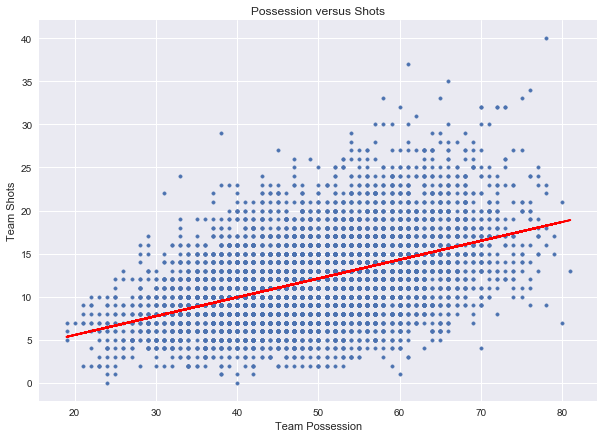

In [17]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn
import numpy as np
from numpy.polynomial.polynomial import polyfit

x=game_df['away_team_possession'].append(game_df['home_team_possession'])

y=game_df['away_team_shots'].append(game_df['home_team_shots'])

def scatter(x,y,title,xlabel,ylabel):
    b, m = polyfit(x, y, 1)
    
    plt.figure(figsize=(10,7))

    plt.plot(x, b + m * x, '-',color='red')

    plt.scatter(x,y, marker='.')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
scatter(x,y,'Possession versus Shots','Team Possession','Team Shots')

I calculate p-value and correlation coefficient for the relationship:

In [18]:
import statsmodels.api as sm

def stats(x,y):
    x=sm.add_constant(x)
    results=sm.OLS(y,x).fit()

    return results.summary()
    
stats(x,y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     1967.
Date:                Mon, 17 Sep 2018   Prob (F-statistic):               0.00
Time:                        20:26:12   Log-Likelihood:                -21100.
No. Observations:                7302   AIC:                         4.220e+04
Df Residuals:                    7300   BIC:                         4.222e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          1.1893      0.250      4.761      0.000         0.700     1.679
None           0.2186      0.005     44.354      0.000         0.209     0.228
==============================================================================
Omnibus:                      329.349   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              394.972
Skew:                           0.496   Prob(JB):                     1.71e-86
Kurtosis:                       3.560   Cond. No.                         249.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Because the correlation coefficient is only .212 (which is smaller than .4), the relationship between team possession and team shots is not statistically significant.

I turn now to the relationship between the number of fouls committed in a game and the number of shots in a game. First, I look at the _total_ number of fouls versus _total_ number of shots. 

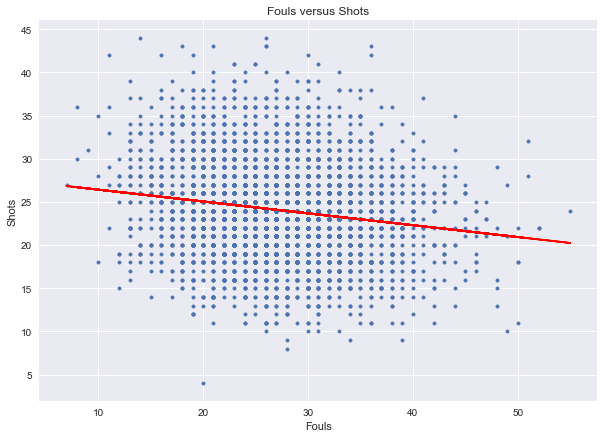

In [19]:
x=game_df['away_team_fouls']+game_df['home_team_fouls']

y=game_df['away_team_shots']+game_df['home_team_shots']

scatter(x,y,'Fouls versus Shots','Fouls','Shots')

In [20]:
stats(x,y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     99.71
Date:                Mon, 17 Sep 2018   Prob (F-statistic):           3.49e-23
Time:                        20:26:23   Log-Likelihood:                -11495.
No. Observations:                3651   AIC:                         2.299e+04
Df Residuals:                    3649   BIC:                         2.301e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         27.7956      0.384     72.295      0.000        27.042    28.549
None          -0.1373      0.014     -9.986      0.000        -0.164    -0.110
==============================================================================
Omnibus:                       43.324   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.673
Skew:                           0.271   Prob(JB):                     1.99e-10
Kurtosis:                       3.008   Cond. No.                         115.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Again, the relationship between shots and fouls in not statistically significant, because R-squared is lower than .4.

Next, I look at the relation between a team's number of fouls committed versus its number of shots. 

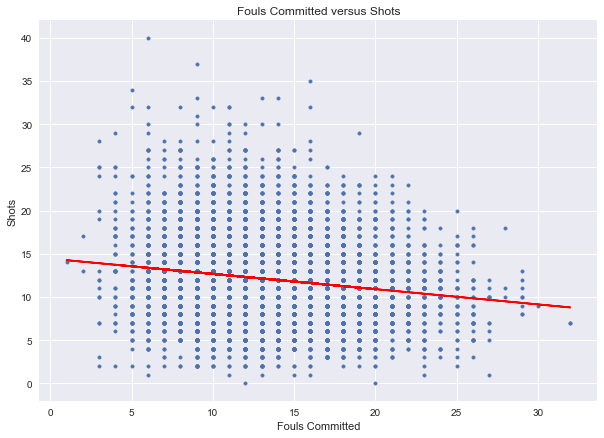

In [21]:
x=pd.concat([game_df['away_team_fouls'],game_df['home_team_fouls']],ignore_index=True)

y=pd.concat([game_df['away_team_shots'],game_df['home_team_shots']],ignore_index=True)

scatter(x,y,'Fouls Committed versus Shots','Fouls Committed','Shots')

In [22]:
stats(x,y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     182.9
Date:                Mon, 17 Sep 2018   Prob (F-statistic):           3.58e-41
Time:                        20:26:35   Log-Likelihood:                -21881.
No. Observations:                7302   AIC:                         4.377e+04
Df Residuals:                    7300   BIC:                         4.378e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         14.4288      0.186     77.644      0.000        14.065    14.793
None          -0.1765      0.013    -13.523      0.000        -0.202    -0.151
==============================================================================
Omnibus:                      454.898   Durbin-Watson:                   1.783
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              567.044
Skew:                           0.604   Prob(JB):                    7.38e-124
Kurtosis:                       3.636   Cond. No.                         46.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

There is no statistically significant relationship in this case either.

Finally, I look at the relation between a team's number of fouls _suffered_ versus its number of shots.

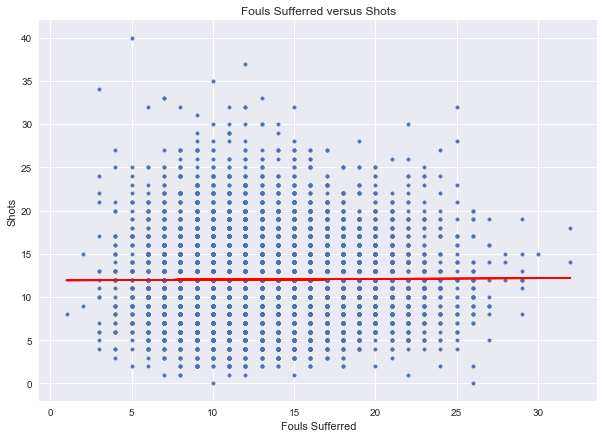

In [23]:
x=game_df['away_team_fouls'].append(game_df['home_team_fouls'])

y=game_df['home_team_shots'].append(game_df['away_team_shots'])

scatter(x,y,'Fouls Sufferred versus Shots','Fouls Sufferred','Shots')

In [24]:
stats(x,y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4484
Date:                Mon, 17 Sep 2018   Prob (F-statistic):              0.503
Time:                        20:26:46   Log-Likelihood:                -21971.
No. Observations:                7302   AIC:                         4.395e+04
Df Residuals:                    7300   BIC:                         4.396e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         11.9156      0.188     63.334      0.000        11.547    12.284
None           0.0088      0.013      0.670      0.503        -0.017     0.035
==============================================================================
Omnibus:                      542.093   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              704.051
Skew:                           0.665   Prob(JB):                    1.31e-153
Kurtosis:                       3.739   Cond. No.                         46.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Unfortunately, none of the relationships investigated are strongly correlated. **Furthermore, for the last relationship we should not reject the null hypothesis that there is no correlation whatsoever between the two variables (because the p-value in this last case is higher than .05).  CHANGE**

### Analysis of specific leagues

Next, I use a league and season of the user's choice, and I show the top goalscorers, top foulers, and players who suffered most fouls. First I get user input:

In [22]:
def get_filters():

    league_name=raw_input ('Please choose a league (valid choices: Premier League,Bundesliga,La Liga,Ligue 1,Serie A):')

    while league_name not in ['Premier League','Bundesliga','La Liga','Ligue 1','Serie A']:

        league_name=raw_input('That is not a valid choice. Please re-enter league:')
        
    league_dict={'Premier League': 1729,
                    'Bundesliga': 7809,
                    'La Liga': 21518,
                    'Ligue 1': 4769,
                    'Serie A': 10257}
    
    league_code=league_dict[league_name]
    
    season=raw_input ('Please enter season (2014/2015 or 2015/2016):')

    while season not in ['2014/2015', '2015/2016']:

        season=raw_input ('That is not a valid choice. Please re-enter season:')
        
    return league_name, league_code, season

league_name,league,season=get_filters()


Please choose a league (valid choices: Premier League,Bundesliga,La Liga,Ligue 1,Serie A):Premier League
Please enter season (2014/2015 or 2015/2016):2014/2015


Below are some statistics about the league and the season chosen. I start with the top scorers:

How many top scorers would you like to display?9


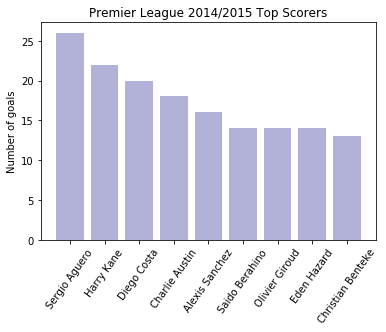

In [82]:
connection=sql.connect('database.sqlite')
cursor=connection.cursor()

temp_df=pd.merge(goal_df,game_df,how='inner',on='match_id')  #join goal dataframe with game dataframe
scorers_df=temp_df[['match_id','league_id','season','scorer','type']]  #keep only columns i need 

criterion=(scorers_df['league_id']==str(league)) & (scorers_df['season']==season)
scorers_df=scorers_df[criterion]          #filter for league and season chosen by user

#create ordered dataframe with top scorers and rename column storing goal number
top_scorers_df=scorers_df.groupby('scorer').count().reset_index()[['scorer','match_id']]
top_scorers_df=top_scorers_df.rename(columns={'match_id':'number_of_goals'})
number=int(raw_input('How many top scorers would you like to display?'))

#select the number (chosen by user) of top scorers to be displayed 
top_scorers_df=top_scorers_df.sort_values('number_of_goals',ascending=False).head(number)

#get player names from relational database 
conn=sql.connect('database.sqlite')

c=conn.cursor()
for i in top_scorers_df.index:
    
    player=top_scorers_df.loc[i,'scorer']
        
    c.execute('SELECT player_name FROM Player WHERE player_api_id={}'.format(player))
    
    top_scorers_df.loc[i,'player']=c.fetchall()[0][0]    
    
pos=np.arange(number)

#create chart
plt.bar(pos,top_scorers_df['number_of_goals'],color='navy',alpha=.3,
        tick_label=top_scorers_df['player'],align = 'center')
plt.xticks(rotation=min(6*number,90))
# plt.legend(['Penalties','Other Goals'])
plt.title('{} {} Top Scorers'.format(league_name,season))
plt.ylabel('Number of goals')

plt.show()

Next I display top scorers, but I differentiate between penalty and non-penalty goals.

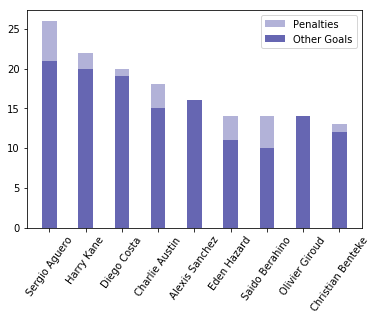

In [121]:
#create dataframe with only top scorers, having goal type info
penalty_df=pd.merge(top_scorers_df,scorers_df,on='scorer',how='left')

#get number of penalty goals for each top scorer
penalty_df=penalty_df[penalty_df['type']=='penalty'].groupby('scorer')['type'].count().reset_index()
#join this with top_scorers dataframe to get penalty and total goals data for each top scorer
penalty_df=pd.merge(penalty_df,top_scorers_df,on='scorer',how='right').rename(columns={'type':'penalties'})
#replace nan values with 0 for each player who didn't score any penalty goals
penalty_df['penalties']=penalty_df['penalties'].apply(lambda x: 0 if pd.isna(x) else x)
penalty_df['penalties']=penalty_df['penalties'].astype(int)   #cast 'penalties' column as int
#create column that captures number of non-penalty goals
penalty_df['non_penalties']=penalty_df['number_of_goals']-penalty_df['penalties']
#sort dataframe by total number of goals
penalty_df=penalty_df.sort_values('number_of_goals',ascending=False)
#create stacked bar chart
plt.bar(pos,penalty_df['penalties'], color='navy',alpha=.3,width=.4,bottom=penalty_df['non_penalties'],tick_label=penalty_df['player'])
plt.bar(pos,penalty_df['non_penalties'],color='navy',alpha=.6,width=.4,tick_label=penalty_df['player'])
plt.xticks(rotation=min(6*number,90))
plt.legend(['Penalties','Other Goals'])
plt.show()

I next show players who fouled the most:

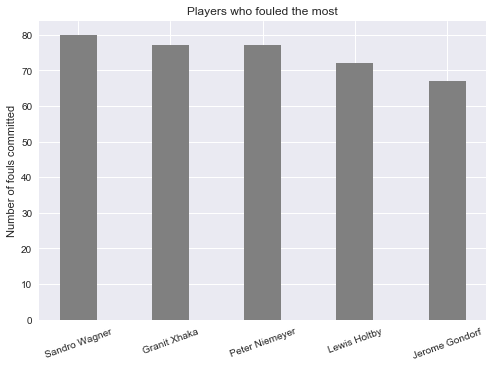

In [27]:
top_foulers_df=player_df[criterion].sort_values('fouls_committed',ascending=False).head()

for i in top_foulers_df.index:
    
    player=top_foulers_df.loc[i,'player']
    
    cursor.execute('SELECT player_name FROM Player WHERE player_api_id={}'.format(player))
    
    top_foulers_df.loc[i,'player']=cursor.fetchall()[0][0]
    
pos=np.arange(5)

plt.bar(pos,top_foulers_df['fouls_committed'],color='grey',width=.4,tick_label=top_foulers_df['player'])

plt.xticks(rotation=20)
plt.title('Players who fouled the most')
plt.ylabel('Number of fouls committed')
plt.show()

Below are the most fouled players:

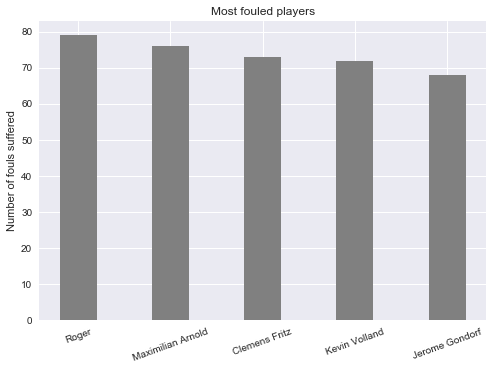

In [28]:
most_fouled_df=player_df[criterion].sort_values('fouls_suffered',ascending=False).head()

for i in most_fouled_df.index:
    
    player=most_fouled_df.loc[i,'player']
    
    cursor.execute('SELECT player_name FROM Player WHERE player_api_id={}'.format(player))
    
    most_fouled_df.loc[i,'player']=cursor.fetchall()[0][0]
    
pos=np.arange(5)

plt.bar(pos,most_fouled_df['fouls_suffered'],color='grey',width=.4,tick_label=most_fouled_df['player'])

plt.xticks(rotation=20)
plt.title('Most fouled players')
plt.ylabel('Number of fouls suffered')
plt.show()

Finally, I show the distribution of goals throughout the 90 minutes of the soccer games. Not surprisingly, most goals will be scored at the end of the two halves (since there is time added so technically the bins are not of the same size. Unfortunately, there is no way to correct for this given the data we have).

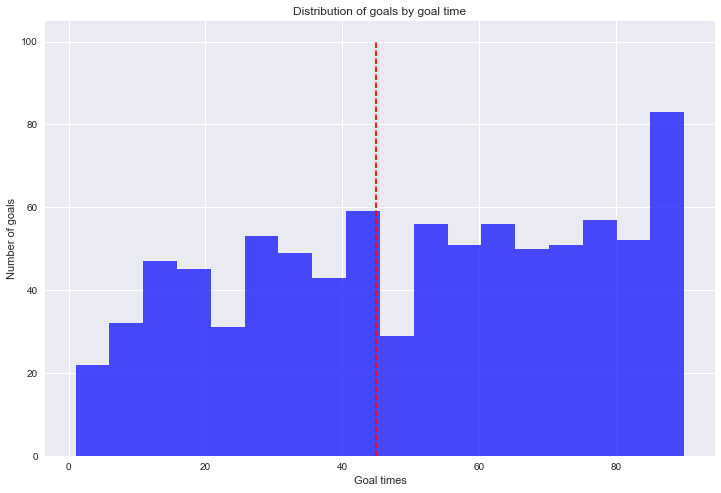

In [29]:
criterion=(df['league_id']==league) & (df['season']==season)
# df.head()
filtered_df=df[criterion]
filtered_df=filtered_df.reset_index(drop=True)
filtered_df.head()
goal_list=[]

for row in range(filtered_df.shape[0]):
    
    for goal in filtered_df.loc[row,'goal_times']:
        
        goal_list.append(goal)
    
goal_list=np.asarray(goal_list)
# print goal_list
plt.figure(figsize=(12,8))

plt.hist(goal_list,18,facecolor='blue',alpha=.7)

plt.xlabel('Goal times')
plt.ylabel('Number of goals')
plt.title('Distribution of goals by goal time')
plt.vlines(45,0,100,color='red',linestyle='dashed',label='Half')